In [ ]:
### Training a local Top Down classifier using CLUSTR HMC Framework on a sample of the amazon data available at 
### http://jmcauley.ucsd.edu/data/amazon/

In [ ]:
#### Created by Deepak Sharma and Govind Gangadhar

In [1]:
import pickle as pk
import numpy as np

In [2]:
cd ../data

/home/ubuntu/category_hmc/data/mrnet_dataset


In [3]:
with open('amazon_data.pkl', 'rb') as f:
    amazon_data = pk.load(f)

In [4]:
len(amazon_data)

484958

In [5]:
amazon_data[:10]

[('Principles of Mgmt + Oper-CSUF Custom C', [['Health & Personal Care']]),
 ('Barnes &amp; Noble NOOK Power Kit in Carbon BNADPN31',
  [['Electronics', 'eBook Readers & Accessories', 'Power Adapters']]),
 ('Barnes &amp; Noble OV/HB-ADP Universal Power Kit',
  [['Electronics', 'eBook Readers & Accessories', 'Power Adapters']]),
 ('Barnes &amp; Noble OV/HB Universal Power Kit for Nook HD &amp; HD+',
  [['Electronics', 'eBook Readers & Accessories', 'Power Adapters']]),
 ('Brain Fitness Exercises Software',
  [['Health & Personal Care', 'Personal Care']]),
 ('Journey to Excellence', [['Sports & Outdoors']]),
 ('101 BlenderBottle Recipes Quick and Easy', [['Health & Personal Care']]),
 ('Aphrodite Reborn - Womens Stories of Hope, Courage and Cancer',
  [['Health & Personal Care']]),
 ('Breast Cancer- My Spiritual Journey', [['Health & Personal Care']]),
 ('Pure Darjeeling Tea- Loose Leaf', [['Grocery & Gourmet Food']])]

In [9]:
def get_freq_table(data):
    freq_table = dict()
    for x in data:
        for y in x[1]:
            for cat in y:
                if cat in freq_table:
                    freq_table[cat] += 1
                else:
                    freq_table[cat] = 1
    return freq_table

In [10]:
def truncate_data(data, freq_table, thres=30):
    truncated_data = []
    for x in data:
        temp_labels = []
        for y in x[1]:
            temp = []
            for label in y:
                if label in freq_table and freq_table[label] >= thres:
                    temp.append(label)
                else:
                    break
            if temp:
                temp_labels.append(temp)
        if temp_labels:
            truncated_data.append((x[0], temp_labels))
    return truncated_data

In [11]:
freq_tab = get_freq_table(amazon_data)

In [12]:
amazon_data = truncate_data(amazon_data, freq_tab)

In [13]:
len(amazon_data)

484958

In [14]:
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

#from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
#from sklearn_hierarchical_classification.constants import ROOT
#from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

In [15]:
from gensim.models import Word2Vec

In [16]:
word2vec_model = Word2Vec.load('/home/ubuntu/categorize_segment/embeddings/skip_gram_ATGC_latest/skip_gram_ATGC_latest')

/home/ubuntu/.local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [17]:
def avg_vec_w2v(sentence,model):
    try:
        vec = np.zeros(128, dtype='float')
        length = 0
        for token in sentence:
            if token in model.wv.vocab:
                length += 1
                vec += model.wv[token]
        if length:
            vec = np.array(vec/length,dtype = np.float32)
        return vec
    except Exception as e:
        raise e

In [18]:
def train_avg_w2v(sentences,model):
    matrix = []
    try:
        for sentence in sentences:
            vec = avg_vec_w2v(sentence, model)
            matrix.append(vec)
        matrix = np.array(matrix)
        return matrix
    except Exception as e:
        raise e

In [19]:
##Check if it is same as above function
def preprocessing(string, stopwords_lst=None):
    try:
        clean_string = ''
        if not isinstance(string, str):
            return []
        for s in string:
            if s.isalpha():
                clean_string += s
            else:
                clean_string += ' '
        if stopwords_lst:
            string_tokens = [i.lower() for i in clean_string.split(' ') if i != '' and i not in stopwords_lst]
        else:
            string_tokens = [i.lower() for i in clean_string.split(' ') if i != '']
        return string_tokens
    except:
        print(string)

#### Create the hierarchy of labels

In [20]:
cl_hierarchy = dict()
for x in amazon_data:
    for labels in x[1]:
        temp = labels
        for i,label in enumerate(temp):
            #print(i)
            #print(label)
            if i == 0:
                if 'ROOT' in cl_hierarchy:
                    if label not in cl_hierarchy['ROOT']:
                        cl_hierarchy['ROOT'].append(label)
                else:
                    cl_hierarchy['ROOT'] = [label]
            else:
                if temp[i-1] in cl_hierarchy:
                    if label not in cl_hierarchy[temp[i-1]]:
                        cl_hierarchy[temp[i-1]].append(label)
                else:
                    cl_hierarchy[temp[i-1]] = [label]

In [21]:
import networkx as nx

In [22]:
hier_G = nx.DiGraph(cl_hierarchy)

In [23]:
len(hier_G.nodes)

141

In [24]:
cl_hierarchy

{'ROOT': ['Health & Personal Care',
  'Electronics',
  'Sports & Outdoors',
  'Grocery & Gourmet Food',
  'Tools & Home Improvement'],
 'Electronics': ['eBook Readers & Accessories',
  'Computers & Accessories',
  'GPS & Navigation',
  'Accessories & Supplies',
  'Television & Video',
  'Camera & Photo',
  'Portable Audio & Video',
  'Security & Surveillance',
  'Home Audio',
  'Car & Vehicle Electronics',
  'Electronics Warranties',
  'Service & Replacement Plans'],
 'eBook Readers & Accessories': ['Power Adapters', 'Reading Lights'],
 'Health & Personal Care': ['Personal Care',
  'Sports Nutrition',
  'Health Care',
  'Medical Supplies & Equipment',
  'Household Supplies',
  'Baby & Child Care',
  'Sexual Wellness',
  'Vitamins & Dietary Supplements'],
 'Sports & Outdoors': ['Exercise & Fitness',
  'Golf',
  'Boating & Water Sports',
  'Hunting & Fishing',
  'Equestrian Sports',
  'Accessories',
  'Fan Shop',
  'Clothing',
  'Cycling',
  'Leisure Sports & Game Room',
  'Racquet Sport

#### Creating Train Test Split by Leaf Node

In [25]:
def aggregate_by_leaf_node(data):
    leaf_nodes_to_index = dict()
    for i, x in enumerate(data):
        for y in x[1]:
            if y[-1] in leaf_nodes_to_index:
                leaf_nodes_to_index[y[-1]].append(i)
            else:
                leaf_nodes_to_index[y[-1]] = [i]
    return leaf_nodes_to_index

In [26]:
temp = aggregate_by_leaf_node(amazon_data)

In [27]:
import random

In [28]:
import numpy as np

In [29]:
def sample_leaf_nodes(leaf_to_index):
    train = []
    complete = []
    for k,v in leaf_to_index.items():
        ids = random.sample(v, int(np.floor(len(v)*0.8)))
        #test_ids = list(set(v) - set(ids))
        train.extend(ids)
        complete.extend(v)
    train = list(set(train))
    test = list(set(complete) - set(train))
    return train,test

In [30]:
def generate_train_test(data):
    label_index_dict = aggregate_by_leaf_node(data)
    train_id, test_id = sample_leaf_nodes(label_index_dict)
    train_data = [data[i] for i in train_id]
    test_data = [data[i] for i in test_id]
    return train_data, test_data

In [31]:
amazon_data = [(x[0], [['ROOT'] + y for y in x[1]]) for x in amazon_data]

In [32]:
tr, te = generate_train_test(amazon_data)

In [33]:
len(tr)

387969

In [34]:
len(te)

96989

In [35]:
labels_train = [[y[-1] for y in x[1]] for x in tr]

In [36]:
labels_test = [[y[-1] for y in x[1]] for x in te]

#### Creating Product Vector for SKUs

In [37]:
sentences_w2v_train = [preprocessing(x[0]) for x in tr]

In [38]:
vecData_train = train_avg_w2v(sentences_w2v_train, word2vec_model)

In [39]:
vecData_train.shape

(387969, 128)

In [40]:
sentences_w2v_test = [preprocessing(x[0]) for x in te]

In [41]:
vecData_test = train_avg_w2v(sentences_w2v_test, word2vec_model)

In [42]:
vecData_test.shape

(96989, 128)

In [43]:
tr[:10]

[('Principles of Mgmt + Oper-CSUF Custom C',
  [['ROOT', 'Health & Personal Care']]),
 ('Barnes &amp; Noble OV/HB Universal Power Kit for Nook HD &amp; HD+',
  [['ROOT', 'Electronics', 'eBook Readers & Accessories', 'Power Adapters']]),
 ('Journey to Excellence', [['ROOT', 'Sports & Outdoors']]),
 ('101 BlenderBottle Recipes Quick and Easy',
  [['ROOT', 'Health & Personal Care']]),
 ('Breast Cancer- My Spiritual Journey', [['ROOT', 'Health & Personal Care']]),
 ('Pure Darjeeling Tea- Loose Leaf', [['ROOT', 'Grocery & Gourmet Food']]),
 ('Power Systems Advanced Strength Training',
  [['ROOT', 'Sports & Outdoors', 'Exercise & Fitness']]),
 ('HoganS Five Lessons (P) - Golf Book',
  [['ROOT', 'Sports & Outdoors', 'Golf']]),
 ('Maptech Waterproof Chart 25- Upper Chesapeake Bay',
  [['ROOT', 'Sports & Outdoors', 'Boating & Water Sports', 'Boating']]),
 ('CML-12DP512 Development Board for the Freescale',
  [['ROOT', 'Electronics', 'Computers & Accessories', 'Computer Components']])]

### Testing the preprocess.py Module 

In [44]:
cd ../src

/home/ubuntu/category_hmc/code


In [45]:
import clustr_hmc.preprocess as pre

In [46]:
path_labels = [x[1] for x in tr]

##### assign_nodes

In [39]:
#dp_test = pre.DataPreprocess(type='LCN')

In [92]:
#hier_G = dp_test.assign_nodes(G=hier_G, labels=path_labels)

In [93]:
#len(hier_G.nodes['eBook Readers & Accessories']['X'])

In [94]:
#for s in hier_G.successors['eBook Readers & Accessories']

### Testing traverse.py
### Testing the training and training strategies

In [47]:
from clustr_hmc.classifier import HierarchicalClassifier

In [48]:
#base_est = svm.SVC(gamma=0.001, kernel="rbf", probability=True)

In [49]:
#lcpn
#hier_class = HierarchicalClassifier(base_estimator=None, class_hierarchy=hier_G, prediction_depth='nmlnp', algorithm='lcpn', root='ROOT', label='leaf', do_transform_label=True, multi_label=True, training_stopping_criteria=None, stopping_criteria=0.5)

In [50]:
#lcn
hier_class = HierarchicalClassifier(base_estimator=None, class_hierarchy=hier_G, prediction_depth='nmlnp', algorithm='lcn', root='ROOT', label='leaf', do_transform_label=False, multi_label=True, training_stopping_criteria=None, training_strategy='siblings', stopping_criteria=0.5)

In [51]:
hier_class.fit(X=vecData_train, y=labels_train)

Reach node -  ROOT
Reach node -  Health & Personal Care
Reach node -  Personal Care
Reach node -  Foot Care
Reach node -  Sports Nutrition
Reach node -  Weight Gainers
Reach node -  Pre-Workout
Reach node -  Health Care
Reach node -  First Aid
Reach node -  Foot Care
Reach node -  Digestion & Nausea
Reach node -  Sleep & Snoring
Reach node -  Medical Supplies & Equipment
Reach node -  Mobility Aids & Equipment
Reach node -  Diabetes Care
Reach node -  Respiratory Aids & Accessories
Reach node -  Household Supplies
Reach node -  Baby & Child Care
Reach node -  Personal Care
Reach node -  Health Care
Reach node -  Sexual Wellness
Reach node -  Sex Furniture
Reach node -  Bondage Gear & Accessories
Reach node -  Vitamins & Dietary Supplements
Reach node -  Electronics
Reach node -  eBook Readers & Accessories
Reach node -  Power Adapters
Reach node -  Reading Lights
Reach node -  Computers & Accessories
Reach node -  Computer Components
Reach node -  Video Projectors
Reach node -  Externa

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


HierarchicalClassifier(algorithm='lcn', base_estimator=None,
                       class_hierarchy=<networkx.classes.digraph.DiGraph object at 0x7f0661fc8240>,
                       do_transform_label=None, include_parent=False,
                       label='leaf', label_transformer=None, mlb_model=None,
                       multi_label=True, prediction_depth='nmlnp',
                       progress_wrapper=None, root='ROOT',
                       stopping_criteria=0.5, training_stopping_criteria=None,
                       training_strategy='siblings')

In [52]:
import dill

In [53]:
with open('hmc_model_amazon_data_09082020.pkl', 'wb') as f:
    dill.dump(hier_class,f)

In [54]:
!ls

clustr_hmc			    hmc_model_lcpn_logistic_train_test.pkl
clustr_hmc_old			    hmc_model_lcpn_svm_train_test.pkl
hmc_decision_trees		    hmc_model.pkl
hmc_model_amazon_data_05082020.pkl  hmcnn
hmc_model_amazon_data_09082020.pkl  hmcnn_train
hmc_model_lcn_logi_train_test.pkl   __init__.py
hmc_model_lcn.pkl		    run_model_local.py
hmc_model_lcn_svm_train_test.pkl    sklearn_hierarchical_classification


In [55]:
#with open('hmc_model_lcn_logi_train_test.pkl', 'rb') as f:
#    hier_class = dill.load(f)

In [56]:
from clustr_hmc.traverse import PredictTraverse

In [57]:
predict = PredictTraverse(G=hier_class.graph_, algorithm=hier_class.algorithm, is_tree=hier_class.is_tree_, is_multi_label=True, prediction_depth=hier_class.prediction_depth, threshold='constant', threshold_value=0.5)

In [60]:
pred_labels = predict.predict(X=vecData_test)

In [59]:
pred_labels

[[['ROOT', 'Sports & Outdoors', 'Fan Shop']],
 [['ROOT', 'Electronics', 'eBook Readers & Accessories', 'Power Adapters'],
  ['ROOT',
   'Sports & Outdoors',
   'Fan Shop',
   'Electronics',
   'eBook Readers & Accessories',
   'Power Adapters']],
 [['ROOT', 'Electronics', 'Computers & Accessories', 'Computer Components'],
  ['ROOT',
   'Sports & Outdoors',
   'Fan Shop',
   'Electronics',
   'Computers & Accessories',
   'Computer Components']],
 [['ROOT', 'Electronics', 'Computers & Accessories', 'Computer Components'],
  ['ROOT',
   'Sports & Outdoors',
   'Fan Shop',
   'Electronics',
   'Computers & Accessories',
   'Computer Components']],
 [['ROOT', 'Electronics', 'Camera & Photo'],
  ['ROOT', 'Electronics', 'Portable Audio & Video'],
  ['ROOT', 'Sports & Outdoors', 'Exercise & Fitness'],
  ['ROOT', 'Sports & Outdoors', 'Fan Shop', 'Electronics', 'Camera & Photo'],
  ['ROOT',
   'Sports & Outdoors',
   'Fan Shop',
   'Electronics',
   'Portable Audio & Video']],
 [['ROOT', 'Groce

#### Evaluation

In [62]:
te[:10]

[('Ultra Pro Golden Age Size Comic Boards (100 Pack)',
  [['ROOT', 'Sports & Outdoors', 'Fan Shop', 'Sports Souvenirs']]),
 ('Barnes &amp; Noble NOOK Power Kit in Carbon BNADPN31',
  [['ROOT', 'Electronics', 'eBook Readers & Accessories', 'Power Adapters']]),
 ('Barnes &amp; Noble OV/HB-ADP Universal Power Kit',
  [['ROOT', 'Electronics', 'eBook Readers & Accessories', 'Power Adapters']]),
 ('Intel Xeon Qc E3-1230 Processor',
  [['ROOT', 'Electronics', 'Computers & Accessories', 'Computer Components']]),
 ('Brain Fitness Exercises Software',
  [['ROOT', 'Health & Personal Care', 'Personal Care']]),
 ('8 pk (8 count) Maine Small Lobster Tails 4/5 oz',
  [['ROOT', 'Grocery & Gourmet Food']]),
 ('Image Guard Comic Backing Boards Magazine Size (100 Pack)',
  [['ROOT', 'Sports & Outdoors', 'Fan Shop', 'Sports Souvenirs']]),
 ('Aphrodite Reborn - Womens Stories of Hope, Courage and Cancer',
  [['ROOT', 'Health & Personal Care']]),
 ('Control Corrective Ceramide Daily Moisture (Normal/Dry) - 

In [100]:
#eval_store = dict()

In [64]:
path_labels_te = [x[1] for x in te]

In [66]:
path_labels_te[:10]

[[['ROOT', 'Sports & Outdoors', 'Fan Shop', 'Sports Souvenirs']],
 [['ROOT', 'Electronics', 'eBook Readers & Accessories', 'Power Adapters']],
 [['ROOT', 'Electronics', 'eBook Readers & Accessories', 'Power Adapters']],
 [['ROOT', 'Electronics', 'Computers & Accessories', 'Computer Components']],
 [['ROOT', 'Health & Personal Care', 'Personal Care']],
 [['ROOT', 'Grocery & Gourmet Food']],
 [['ROOT', 'Sports & Outdoors', 'Fan Shop', 'Sports Souvenirs']],
 [['ROOT', 'Health & Personal Care']],
 [['ROOT', 'Health & Personal Care']],
 [['ROOT', 'Electronics', 'Camera & Photo', 'Accessories']]]

In [67]:
from clustr_hmc import metrics

In [68]:
precision_h = metrics.h_precision_score(path_labels_te, pred_labels)

In [69]:
recall_h = metrics.h_recall_score(path_labels_te, pred_labels)

In [70]:
h_f1 = metrics.h_fbeta_score(path_labels_te, pred_labels)

In [71]:
h_f1

0.6683812434852965

In [72]:
precision_h

0.5415613409246616

In [186]:
values = dict()
for s in hier_class.graph_.successors('ROOT'):
    values[s] = node_precision_recall_scores(path_labels_te, pred_labels, s, level=1)

In [218]:
labels = dict()
for k,v in values.items():
    labels[k] = str(round(v[0],2))

In [219]:
labels

{'FMCG': '0.97',
 'FMCD': '0.91',
 'Hardware': '0.67',
 'Pharmaceuticals and Medical Supplies': '0.44',
 'Sports & Fitness Equipment': '0.6',
 'Agriculture': '0',
 'Stationery': '1.0',
 'Automobiles and Accessories': '0',
 'Interiors & Furnishing': '1.0',
 'Fashion Accessories and Luggage': '1.0',
 'Toys': '0.5'}

In [234]:
model_logistic_fmcg = hier_class.graph_.nodes['FMCG']['classifier']

In [235]:
pred_probs = model_logistic_fmcg.predict_proba(vecData_test)

In [237]:
pred_probs.shape

(3051, 2)

In [239]:
pred_labels_fmcg, ind = _filter_labels(path_labels_te, 'FMCG', 1)

In [242]:
not_fmcg_ind = [i for i in range(len(path_labels_te)) if i not in ind]

In [244]:
fmcg_pred_probs = [pred_probs[i,0] for i in ind] + [pred_probs[i,0] for i in not_fmcg_ind]

In [245]:
y_fmcg = ['FMCG']*len(ind) + ['NOT_FMCG']*len(not_fmcg_ind)

In [249]:
from sklearn.metrics import roc_curve, auc

In [247]:
fpr,tpr,threshold = roc_curve(y_fmcg, fmcg_pred_probs, pos_label='FMCG')

In [250]:
roc = auc(fpr, tpr)

In [251]:
roc

0.9699565484827455

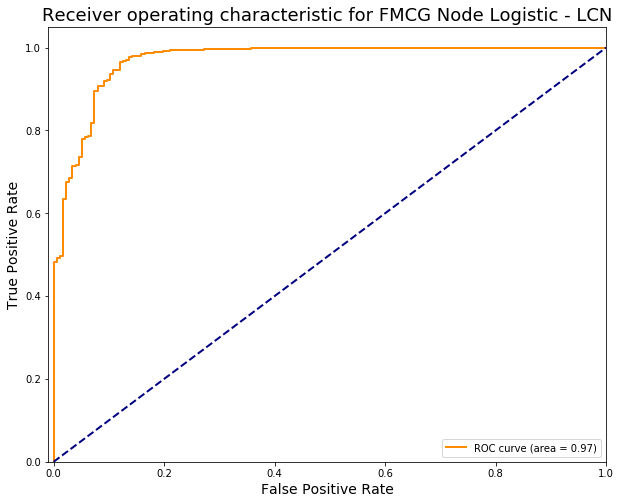

In [256]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic for FMCG Node Logistic - LCN', fontsize=18)
plt.legend(loc="lower right")

plt.show()

In [181]:
fmcg_pre, fmcg_recall = node_precision_recall_scores(path_labels_te, pred_labels, 'FMCG', level=1)

In [183]:
fmcg_recall

0.9861207494795281

In [220]:
H = hier_class.graph_.subgraph(['ROOT'] + list(values.keys()))

In [221]:
H

In [25]:
from scipy.sparse import csr_matrix
import numpy as np

In [193]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


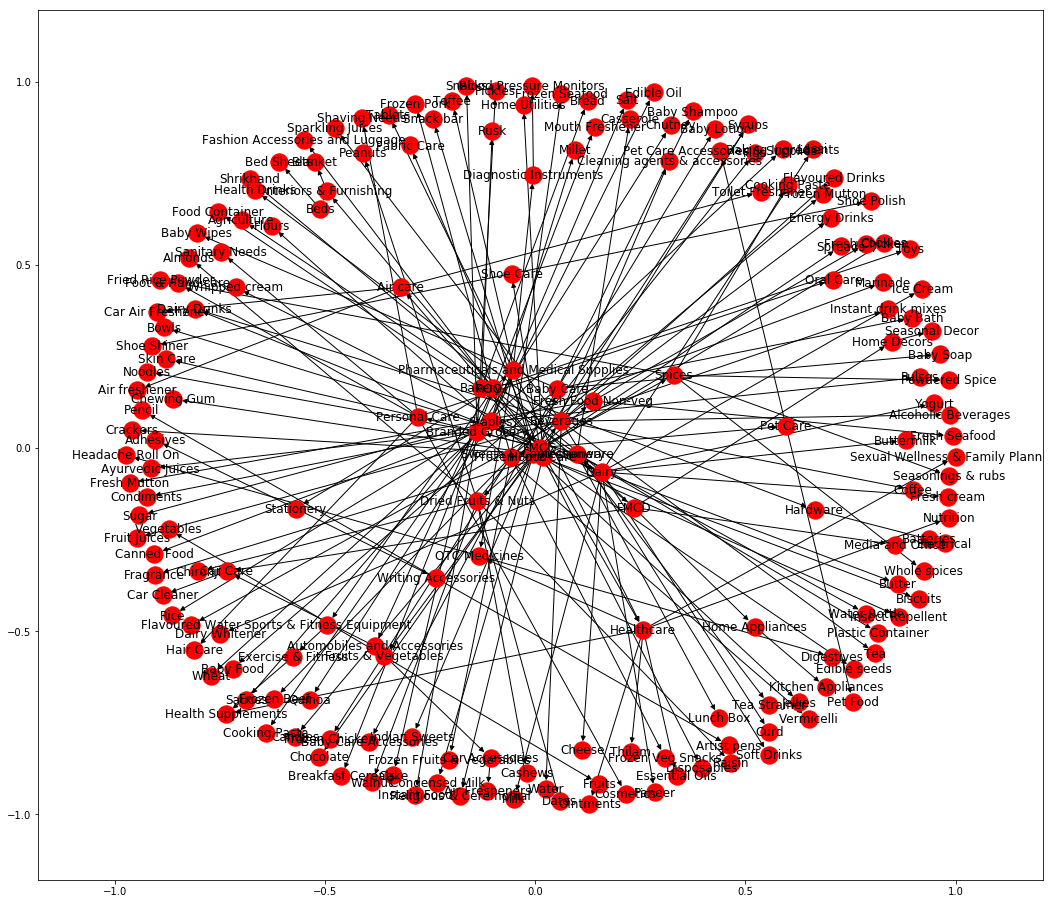

In [28]:
plt.figure(figsize=(18,16))
nx.draw_networkx(hier_G)

In [76]:
import networkx as nx
import random


def hierarchy_pos(G, root=None, width=2, vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    #if not nx.is_tree(G):
    #    raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=2., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [77]:
new_labels = dict()
count = 1
for node in hier_G.nodes:
    new_labels[node] = str(count)
    count += 1

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
import networkx as nx
#G=nx.Graph()
#G.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
#                  (5,11), (5,12), (6,13)])
pos = hierarchy_pos(hier_class.graph_,'ROOT')    
nx.draw(hier_class.graph_, pos=pos, with_labels=True, font_size=14, node_color='gray', alpha=0.7, font_color='red', font_weight='bold')
plt.show()
#plt.savefig('hierarchy.png')

RecursionError: maximum recursion depth exceeded while calling a Python object